In [2]:
import pandas as pd
from sklearn import *
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

In [3]:
pd.set_option('max_columns', 100)
fulldata1 = pd.read_csv('data.csv');
fulldata1.head(4)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4


In [16]:
fulldata = fulldata1.copy()
fulldata['matchup'] = fulldata['matchup'].map(lambda x: x.split()[1])
fulldata.drop(['game_event_id', 'game_id', 'lat', 'lon', 'team_id', 'team_name', 'shot_id', 'game_date', 'opponent'], axis=1, inplace=True)

actiontypes = dict(fulldata.action_type.value_counts())
fulldata['type'] = fulldata.apply(lambda row: row['action_type'] if actiontypes[row['action_type']] > 20\
                          else row['combined_shot_type'], axis=1)

fulldata.drop(['action_type', 'combined_shot_type'], axis=1, inplace=True)

fulldata['time_remaining'] = fulldata.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis=1)
fulldata['last_moments'] = fulldata.apply(lambda row: 1 if row['time_remaining'] < 3 else 0, axis=1)
fulldata['distance'] = fulldata.apply(lambda row: row['shot_distance'] if row['shot_distance'] <45 else 45, axis=1)

# 'action_type', 'combined_shot_type',
text_columns = ['type', 'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'matchup'] #, 'opponent'] # 'action_type', 'combined_shot_type' , 'game_date'
# get_dummies could be used istead of this code:
for col in text_columns:
    uniq_words = fulldata[col].unique()
    for w in uniq_words:
        fulldata[w] = fulldata[col].apply(lambda x: 1 if x==w else 0)
#     uniq_words = dict(enumerate(uniq_words, 1)) # 1 to enumerate from 1
#     uniq_words = {v:k for k,v in uniq_words.items()}
#     fulldata = fulldata.replace({col: uniq_words})
fulldata.drop(text_columns, axis=1, inplace=True)
fulldata.head(4)

,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,time_remaining,last_moments,distance,Jump Shot,Driving Dunk Shot,Layup Shot,Running Jump Shot,Driving Layup Shot,Reverse Layup Shot,Reverse Dunk Shot,Slam Dunk Shot,Turnaround Jump Shot,Tip Shot,Running Hook Shot,Alley Oop Dunk Shot,Dunk Shot,Alley Oop Layup shot,Dunk,Driving Finger Roll Shot,Running Layup Shot,Finger Roll Shot,Fadeaway Jump Shot,Hook Shot,Jump Hook Shot,Layup,Jump Bank Shot,Bank Shot,Driving Finger Roll Layup Shot,Fadeaway Bank shot,Pullup Jump shot,Finger Roll Layup Shot,Turnaround Fadeaway shot,Driving Reverse Layup Shot,Driving Slam Dunk Shot,Step Back Jump shot,Turnaround Bank shot,Floating Jump shot,Running Bank shot,Driving Jump shot,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,1996-97,1997-98,1998-99,1999-00,2PT Field Goal,3PT Field Goal,Right Side(R),Left Side(L),Left Side Center(LC),Right Side Center(RC),Center(C),Back Court(BC),Mid-Range,Restricted Area,In The Paint (Non-RA),Above the Break 3,Right Corner 3,Backcourt,Left Corner 3,16-24 ft.,8-16 ft.,Less Than 8 ft.,24+ ft.,Back Court Shot,@,vs.
0,167,72,10,1,0,27,18,NaN,627,0,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,-157,0,10,1,0,22,15,0.0,622,0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,-101,135,7,1,0,45,16,1.0,465,0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,138,175,6,1,0,52,22,0.0,412,0,22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [17]:
data_test = fulldata[pd.isnull(fulldata['shot_made_flag'])]
data = fulldata[pd.notnull(fulldata['shot_made_flag'])]
data.head(4)

,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,time_remaining,last_moments,distance,Jump Shot,Driving Dunk Shot,Layup Shot,Running Jump Shot,Driving Layup Shot,Reverse Layup Shot,Reverse Dunk Shot,Slam Dunk Shot,Turnaround Jump Shot,Tip Shot,Running Hook Shot,Alley Oop Dunk Shot,Dunk Shot,Alley Oop Layup shot,Dunk,Driving Finger Roll Shot,Running Layup Shot,Finger Roll Shot,Fadeaway Jump Shot,Hook Shot,Jump Hook Shot,Layup,Jump Bank Shot,Bank Shot,Driving Finger Roll Layup Shot,Fadeaway Bank shot,Pullup Jump shot,Finger Roll Layup Shot,Turnaround Fadeaway shot,Driving Reverse Layup Shot,Driving Slam Dunk Shot,Step Back Jump shot,Turnaround Bank shot,Floating Jump shot,Running Bank shot,Driving Jump shot,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,1996-97,1997-98,1998-99,1999-00,2PT Field Goal,3PT Field Goal,Right Side(R),Left Side(L),Left Side Center(LC),Right Side Center(RC),Center(C),Back Court(BC),Mid-Range,Restricted Area,In The Paint (Non-RA),Above the Break 3,Right Corner 3,Backcourt,Left Corner 3,16-24 ft.,8-16 ft.,Less Than 8 ft.,24+ ft.,Back Court Shot,@,vs.
1,-157,0,10,1,0,22,15,0.0,622,0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,-101,135,7,1,0,45,16,1.0,465,0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,138,175,6,1,0,52,22,0.0,412,0,22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,6,2,0,19,0,1.0,379,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [18]:
r_X, r_Y = data.ix[:, data.columns!='shot_made_flag'],  data['shot_made_flag']

In [ ]:
# one hot encoding для всех номинальных признаков
# kmeans. fit на train. transform для train и на test

In [19]:
dTrain, dTest, YTrain, YTest = model_selection.train_test_split(r_X,r_Y, test_size=0.3, random_state=1)
# dTrain.drop('shot_id', axis=1, inplace=True)
# dTest.drop('shot_id', axis=1, inplace=True)

In [38]:

# r_X.drop('shot_id', axis=1, inplace=True)

In [61]:
XGBoost = xgb.XGBClassifier(max_depth=6, n_estimators=1100, learning_rate=0.012, max_delta_step=5, subsample=0.72, colsample_bytree=0.2, seed=1)
# xgbRegr = xgb.XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=400) #best

In [62]:
XGBoost.fit(dTrain, YTrain)
# XGBoost.fit(r_X, r_Y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0, learning_rate=0.012, max_delta_step=5, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=0.72)

In [63]:
aucXGBTrain = metrics.roc_auc_score(YTrain, XGBoost.predict_proba(dTrain)[:,1])
aucXGBTest = metrics.roc_auc_score(YTest, XGBoost.predict_proba(dTest)[:,1])
print('XGBoost:       {:6.4}  {:6.4}'.format(aucXGBTrain, aucXGBTest))
# 0.7072
## 7095

XGBoost:       0.7872  0.7077


In [239]:
# r_test_acc = xgbRegr.predict(data_test.ix[:, data_test.columns!='shot_made_flag'])
# r_res = list(zip(indices, r_test_acc))
# for z in r_res[:3]:
#     print(z)

In [165]:
indices = [x+1 for x in data_test.index]
# test_acc = XGBoost.predict_proba(data_test.ix[:, data_test.columns!='shot_made_flag'])[:,1]
test_acc = XGBoost.predict_proba(r_X)[:,1]
res = list(zip(indices, test_acc))
for z in res[:5]:
    print(z)
with open('result_classiffier.csv', 'w') as f:
    f.write('shot_id,shot_made_flag\n')
    for s,m in res:
        f.write(str(s) + ',' +str(m)+'\n')

(1, 0.40818903)
(8, 0.44356674)
(17, 0.49750447)
(20, 0.94159991)
(33, 0.40088201)


In [77]:
# with open('result_regressor.csv', 'w') as f:
#     f.write('shot_id,shot_made_flag\n')
#     for s,m in r_res:
#         f.write(str(s) + ',' +str(m)+'\n')

In [14]:
def fit_and_test_classifier(classifier):
    classifier.fit(dTrain, YTrain)
    aucXGBTrain = metrics.roc_auc_score(YTrain, classifier.predict_proba(dTrain)[:,1])
    aucXGBTest = metrics.roc_auc_score(YTest, classifier.predict_proba(dTest)[:,1])
    print('XGBoost:       {:6.4}  {:6.4}'.format(aucXGBTrain, aucXGBTest))

In [200]:
XGBoost.feature_importances_
# 7057

array([ 0.08154062,  0.0251117 ,  0.11823598,  0.10632136,  0.0259391 ,
        0.03309615,  0.00256495,  0.06292404,  0.08323681,  0.06735066,
        0.00091014,  0.01187324,  0.00885322,  0.00777759,  0.13246731,
        0.02035413,  0.08766341,  0.1220834 ,  0.00169618], dtype=float32)

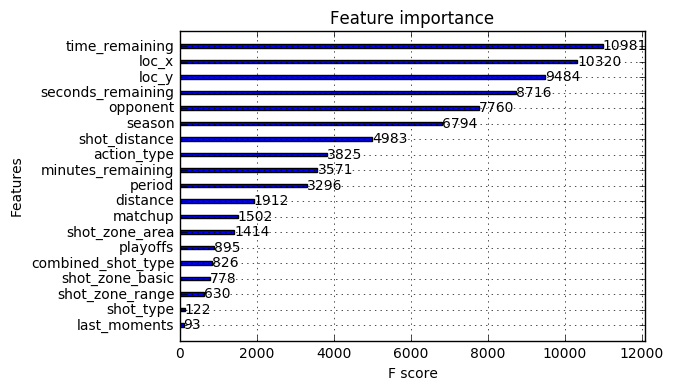

In [24]:
xgb.plot_importance(XGBoost)

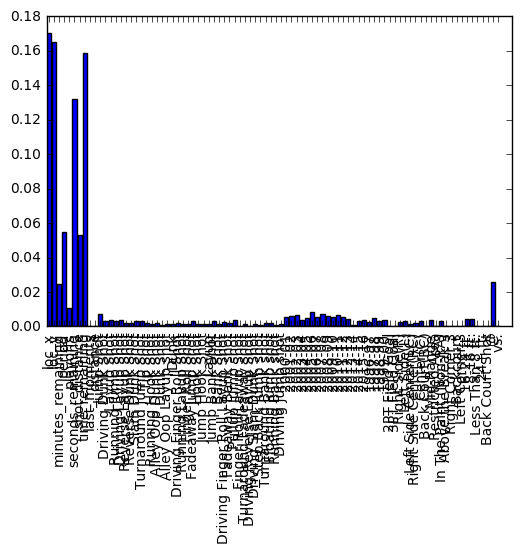

In [33]:
plt.rcParams.update({'font.size': 10})
labels = dTrain.columns
cols = list(labels)
plt.bar(range(len(XGBoost.feature_importances_)), XGBoost.feature_importances_)
plt.xticks(np.arange(len(cols)) + 0.4, labels, rotation='vertical')
plt.show()

In [193]:
r_X.columns

Index(['action_type', 'combined_shot_type', 'loc_x', 'loc_y',
       'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_type', 'shot_zone_area',
       'shot_zone_basic', 'shot_zone_range', 'game_date', 'matchup',
       'opponent', 'shot_id', 'time_remaining', 'last_moments'],
      dtype='object')